<a href="https://colab.research.google.com/github/IverMartinsen/ColabNotebooks/blob/main/trial12august2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import modules and images { form-width: "40%" }

import sys
sys.path.append(r'/content/drive/MyDrive/src/Python')      

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from modules.imageloader import imageloader
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import RandomZoom, RandomRotation, RandomFlip

# turn off interactive plotting to avoid plots popping up during trials
plt.ioff()

# path to image folder
path = r'/content/drive/MyDrive/Data/Torskeotolitter/standard'

img_size = (128, 128)
img_shape = img_size + (3,)
num_splits = 5
batch_size = 32
initial_epochs = 100

# import images
sets = imageloader(path, img_size, 5, seed=123, mode='RGB')

Total number of images: 610
Total number of classes: 2
----------------------------
5 subsets with 122 images


Instructions for updating:
Use `tf.data.Dataset.random(...)`.
Epoch 1/100
12/12 [==============================] - 6s 168ms/step - loss: 0.7169 - accuracy: 0.5703 - val_loss: 0.6198 - val_accuracy: 0.7049
Epoch 2/100
12/12 [==============================] - 1s 52ms/step - loss: 0.6293 - accuracy: 0.6432 - val_loss: 0.5612 - val_accuracy: 0.7295
Epoch 3/100
12/12 [==============================] - 1s 51ms/step - loss: 0.5956 - accuracy: 0.6693 - val_loss: 0.5276 - val_accuracy: 0.7623
Epoch 4/100
12/12 [==============================] - 1s 52ms/step - loss: 0.5489 - accuracy: 0.7448 - val_loss: 0.5393 - val_accuracy: 0.7213
Epoch 5/100
12/12 [==============================] - 1s 52ms/step - loss: 0.5390 - accuracy: 0.7344 - val_loss: 0.4965 - val_accuracy: 0.7869
Epoch 6/100
12/12 [==============================] - 1s 54ms/step - loss: 0.5417 - accuracy: 0.7344 - val_loss: 0.4925 - val_accuracy: 0.7869
Epoch 7/100
12/12 [==============================] - 1s 52ms/step - loss: 0.5074 - ac

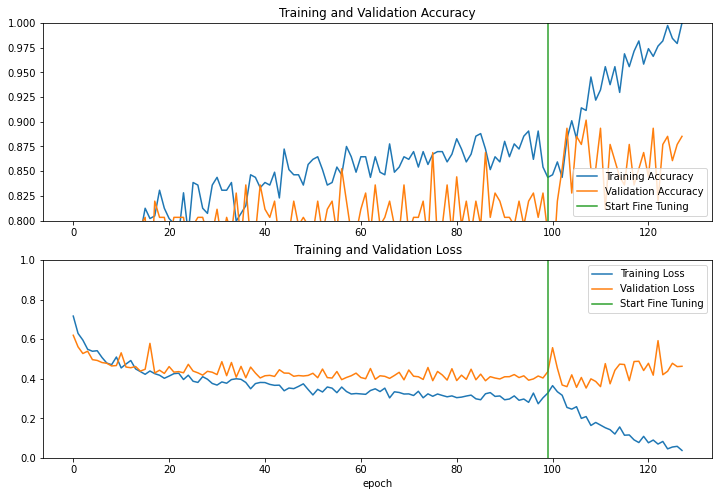

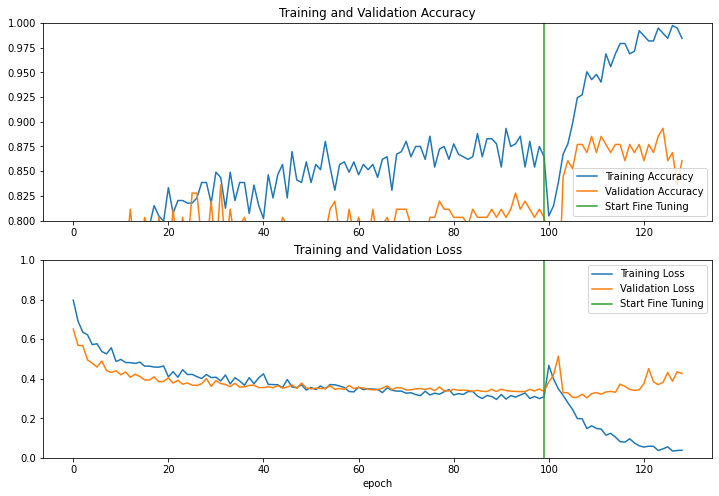

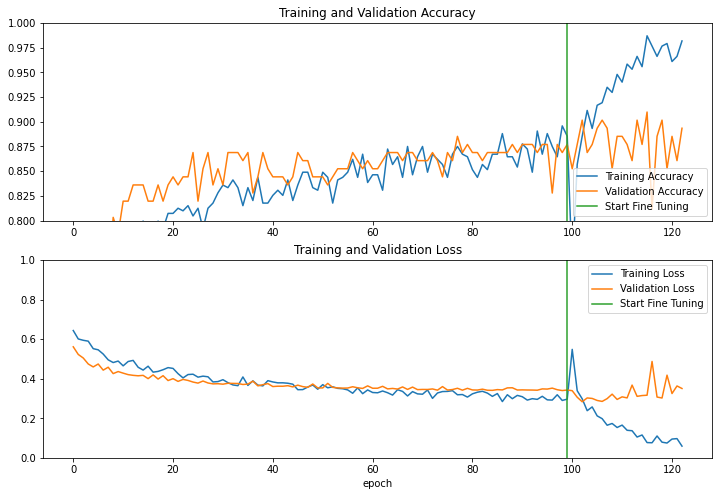

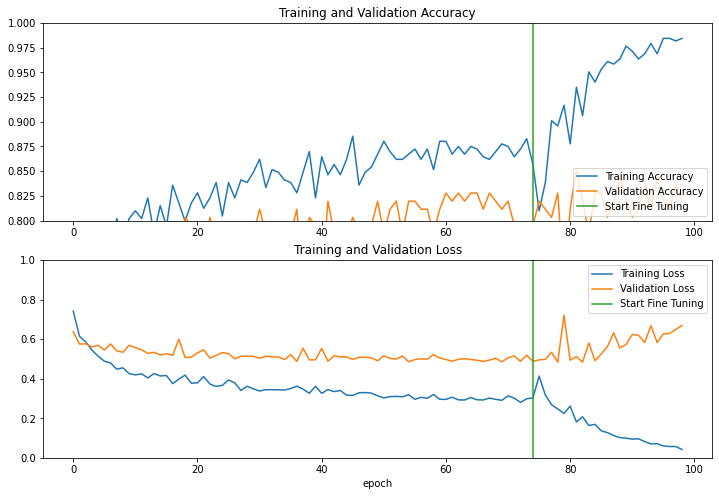

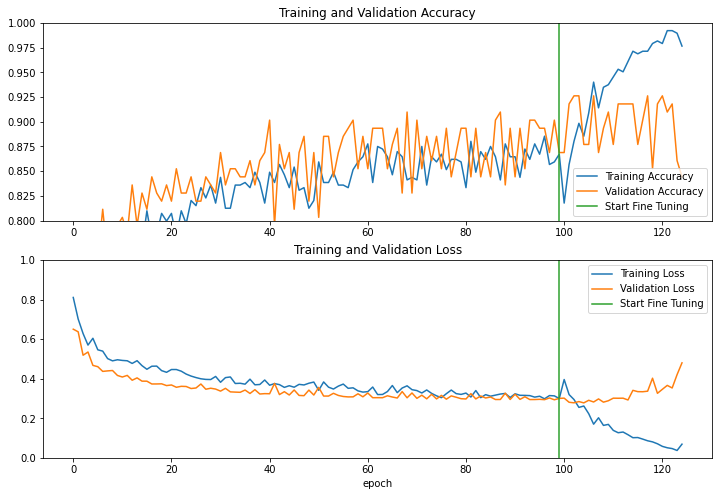

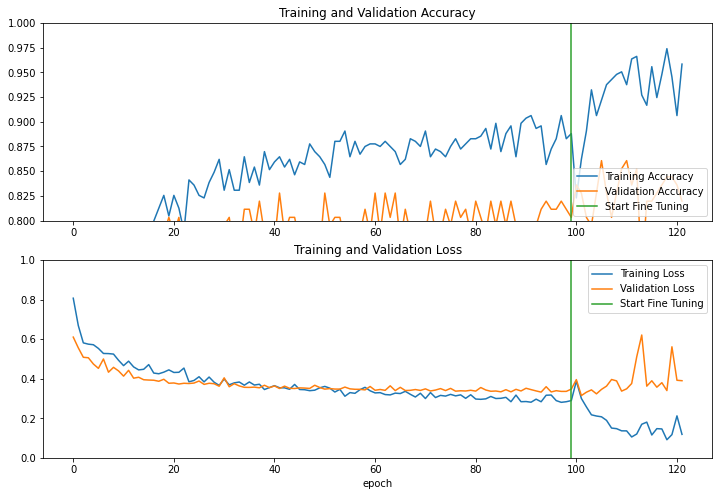

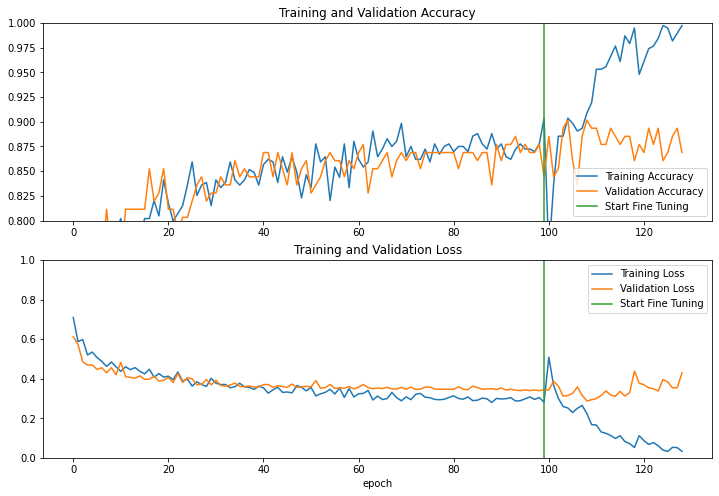

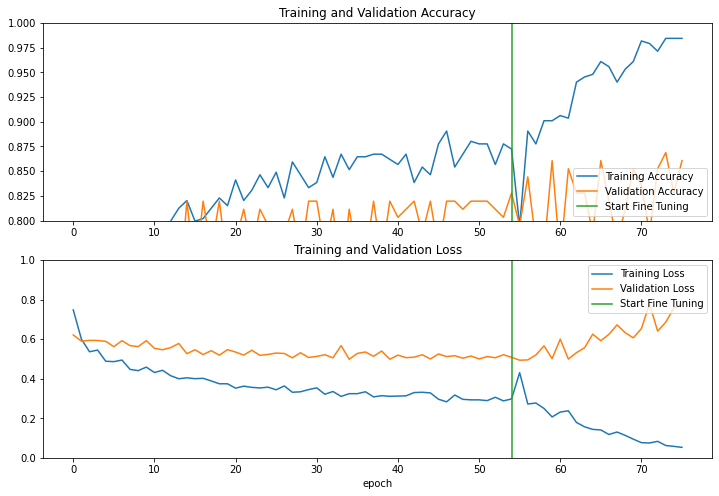

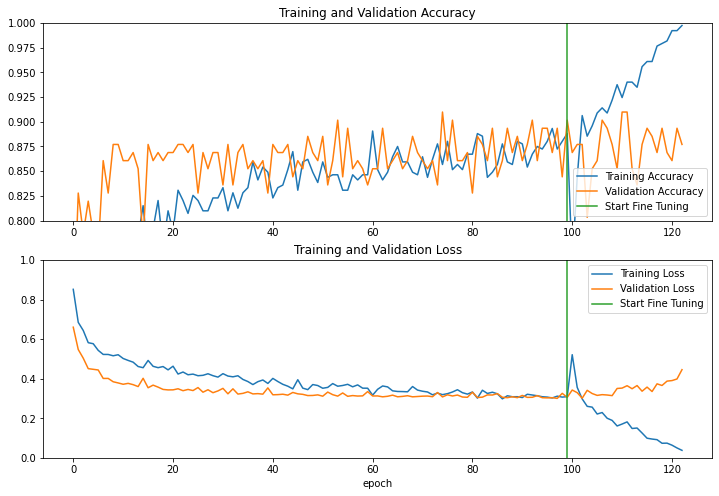

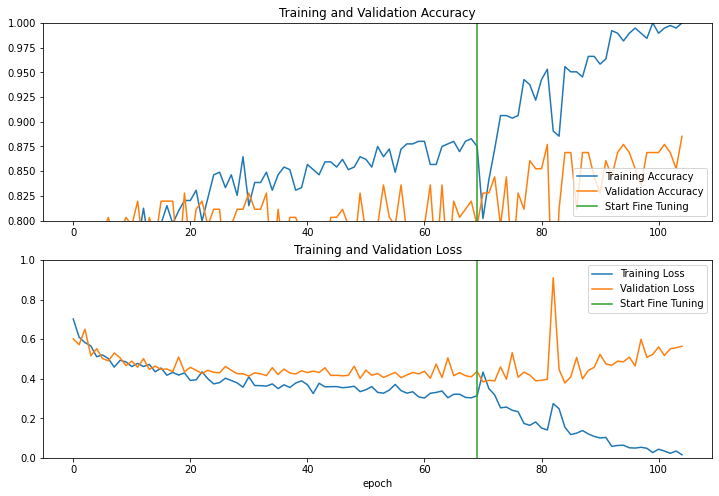

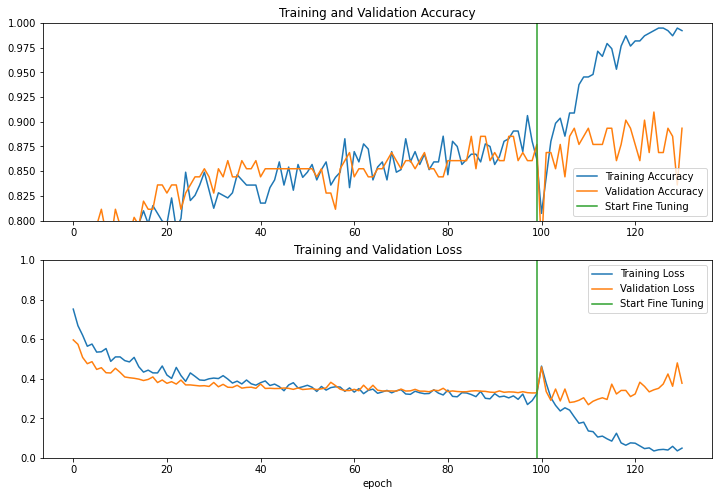

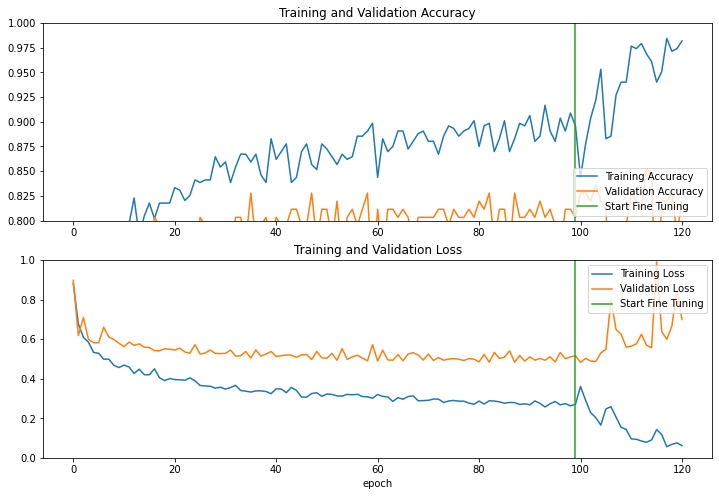

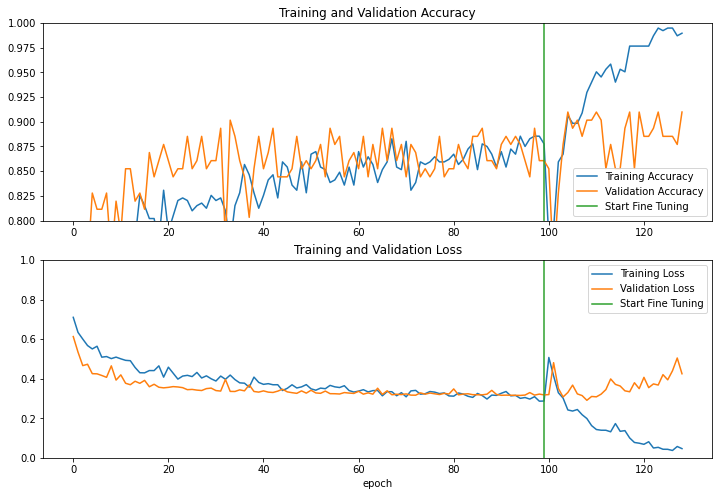

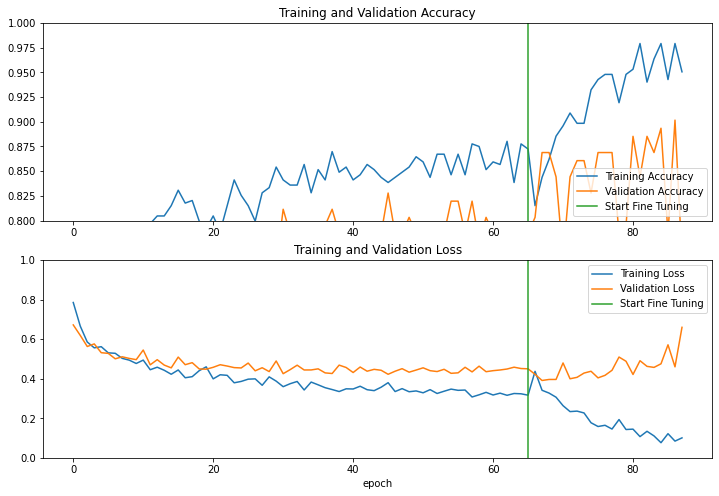

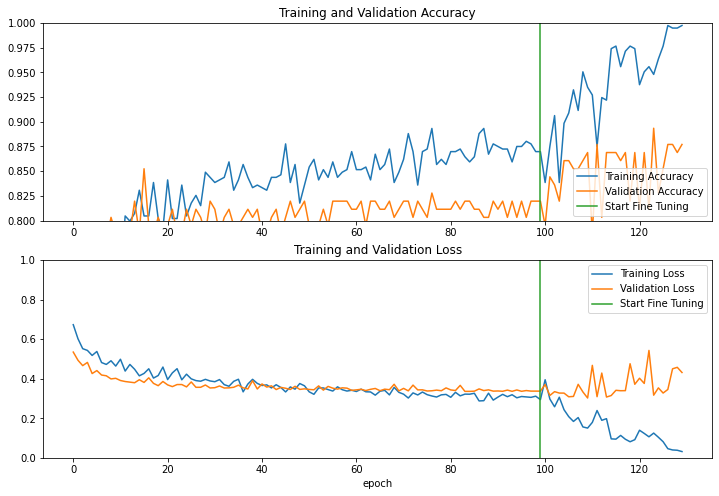

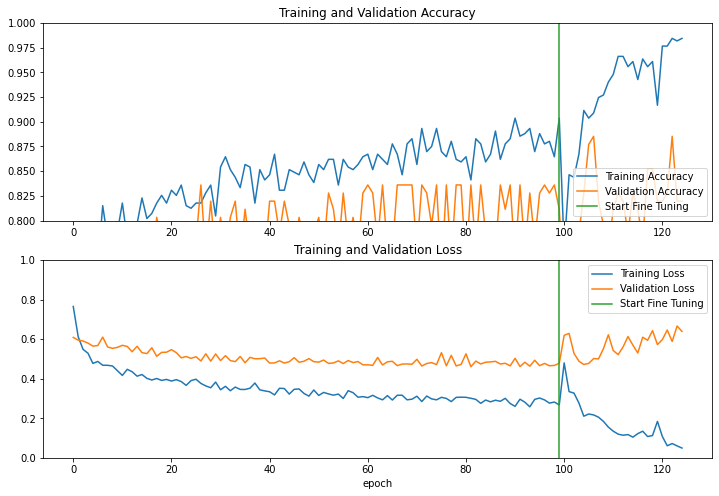

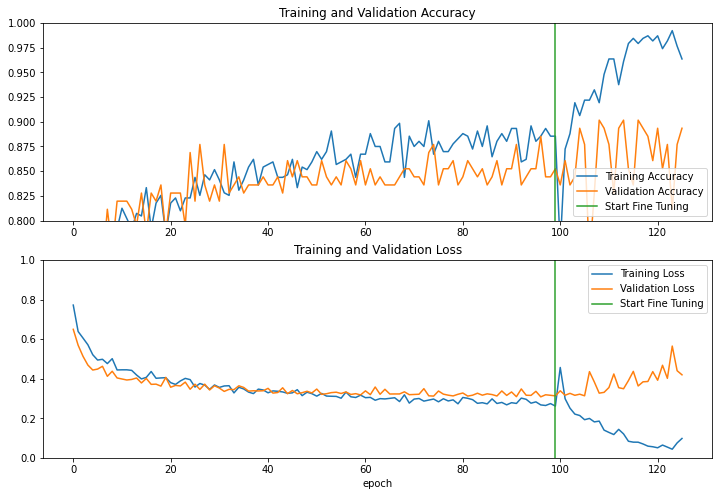

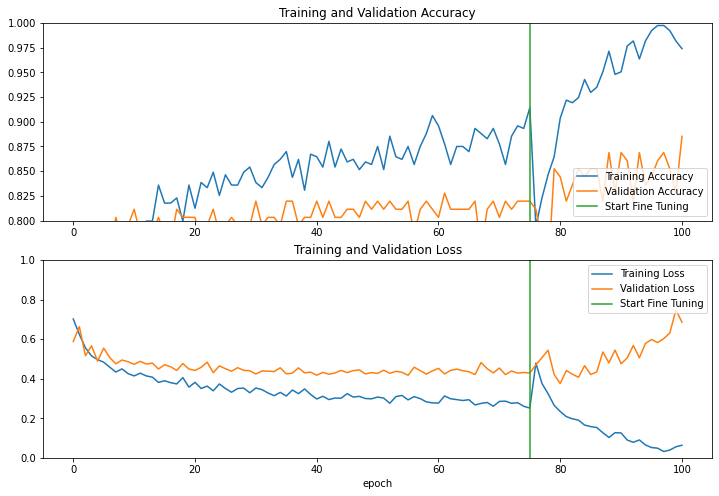

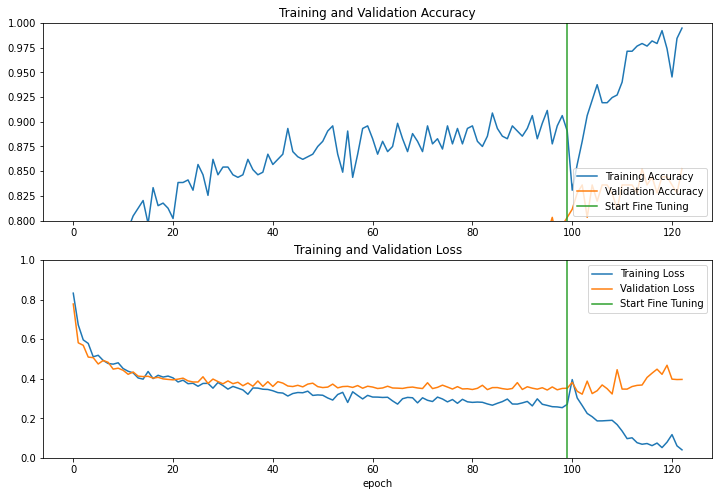

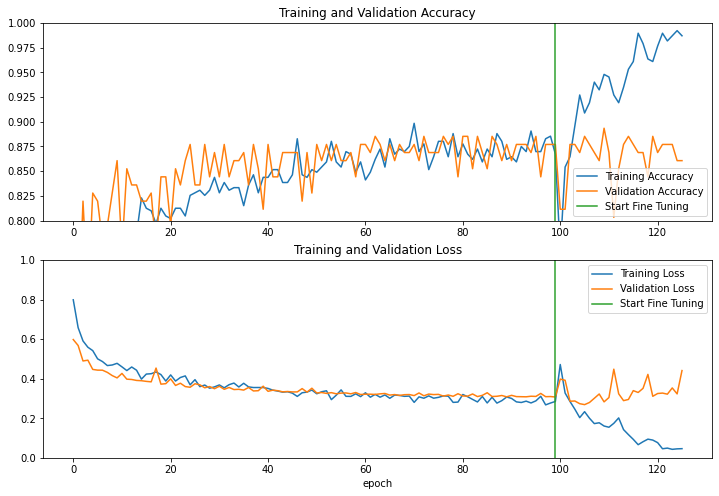

In [ ]:
#@title Train model { form-width: "40%" }

# path to folder where output images and results are stored
destination = r'/content/drive/MyDrive/Forsøk/Forsøk 19.08.2021 (notaugmented)'

# make a new folder where learning curves are stored
folder_name = 'Learning curves'
os.makedirs(destination + '/' + folder_name, exist_ok=True)

# DataFrame for individal test scores for all trials
individual_results = pd.DataFrame()

# DataFrame for class-wise accuracies for all trials
summary_results = pd.DataFrame()

# counter to keep track of trials
trial_num = 0

# to avoid error on del model on first trial
model = None

for test_ds in sets:
    for valid_ds in (ds for ds in sets if ds != test_ds):
        
        trial_num += 1
        
        generators = [ds for ds in sets if ds not in (test_ds, valid_ds)]
        
        x_tr = np.concatenate([generator['images'] for generator in generators])
        y_tr = np.concatenate([generator['labels'] for generator in generators])
        
        x_va = valid_ds['images']
        y_va = valid_ds['labels']
        
        # resample training data to balance out the classes
        negative_ds = tf.data.Dataset.from_tensor_slices(
            (x_tr[np.where(y_tr == 0)],
             y_tr[np.where(y_tr == 0)])).repeat()

        positive_ds = tf.data.Dataset.from_tensor_slices(
            (x_tr[np.where(y_tr == 1)], 
             y_tr[np.where(y_tr == 1)])).repeat()
        
        resampled_ds = tf.data.experimental.sample_from_datasets(
            [negative_ds, positive_ds], 
            weights=[0.5, 0.5])
        
        resampled_ds = resampled_ds.batch(batch_size)

        # With `clear_session()` called at the beginning,
        # Keras starts with a blank state at each iteration
        tf.keras.backend.clear_session()
        
        del model

        # Initialize base model using MobileNetV2 pretrained on imagenet data.
        # By using include_top=False we only include the feature extraction
        # layers. 
        base_model = tf.keras.applications.MobileNetV2(
            input_shape=img_shape,
            include_top=False,
            weights='imagenet'
            )

        # Fine-tune from this layer onwards
        fine_tune_at = len(base_model.layers)

        # Freeze all the layers before the `fine_tune_at` layer
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        # Define full model. By calling 'training=False' we make the base
        # model run in inference mode, e.g. batch normalization parameters
        # are not updated, and dropout is not being used. 
        inputs = tf.keras.Input(shape=img_shape)
        x = preprocess_input(inputs)
        
        # data augmentation
        #x = RandomRotation((-0.2, 0.2))(x)
        #x = RandomZoom((-0.2, 0.2), (-0.2, 0.2))(x)
        #x = RandomFlip("horizontal")(x)

        x = base_model(x, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.2)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = tf.keras.Model(inputs, outputs)

        # set a high base learning rate for initial training
        base_learning_rate = 1e-3
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy']
            )

        # set early stopping
        callbacks = [tf.keras.callbacks.EarlyStopping(
                patience=20, restore_best_weights=True)]

        # fit model
        history = model.fit(resampled_ds,
                            epochs=initial_epochs,
                            steps_per_epoch=12,
                            validation_data=(x_va, y_va),
                            callbacks=callbacks)

        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_run = len(acc)

        # Unfreeze the base_model. Note that it keeps running in inference mode
        # since we passed `training=False` when calling it. This means that
        # the batchnorm layers will not update their batch statistics.
        # This prevents the batchnorm layers from undoing all the training
        # we've done so far.
        base_model.trainable = True

        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy'],
        )

        history_fine = model.fit(
            resampled_ds,
            epochs=100,
            steps_per_epoch=12,
            validation_data=(x_va, y_va),
            callbacks=callbacks)

        acc += history_fine.history['accuracy']
        val_acc += history_fine.history['val_accuracy']

        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']

        # plot loss and accuracy and save figure
        plt.figure(figsize=(12, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.ylim([0.8, 1])
        plt.plot([epochs_run-1,epochs_run-1],
                plt.ylim(), label='Start Fine Tuning')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.ylim([0, 1.0])
        plt.plot([epochs_run-1,epochs_run-1],
                plt.ylim(), label='Start Fine Tuning')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        
        plt.savefig(
            fname=destination + '/' + folder_name + '/trial' + 
            str(trial_num))

        # evaluate model on test set and store results in DataFrames
        predictions = model.predict(test_ds['images'])
        labels = predictions.round()
        
        dataframe = pd.DataFrame(
                predictions.flatten(),
                index=test_ds['filenames'],
                columns=[trial_num])
        
        individual_results = pd.merge(
            individual_results, 
            dataframe, 
            how='outer', 
            left_index=True, 
            right_index=True
            )
        
        # compute class-wise accuracy
        idx = np.where(test_ds['labels'] == 0)

        acc_0 = np.sum(
            test_ds['labels'][idx] == labels.flatten()[idx]) / len(test_ds['labels'][idx])

        idx = np.where(test_ds['labels'] == 1)

        acc_1 = np.sum(
            test_ds['labels'][idx] == labels.flatten()[idx]) / len(test_ds['labels'][idx])
        
        dataframe = pd.DataFrame(
                [model.evaluate(test_ds['images'], test_ds['labels'])[1], acc_0, acc_1],
                index=['Accuracy', 'cc', 'neac'],
                columns=[trial_num])
        
        summary_results = pd.merge(
            summary_results, 
            dataframe, 
            how='outer', 
            left_index=True, 
            right_index=True)

individual_results.to_excel(destination + '/individual_results.xlsx')
summary_results.to_excel(destination + '/summary_results.xlsx')
individual_scores = (-np.log(1 / individual_results - 1))
individual_scores.to_excel(destination + '/individual_scores.xlsx')
individual_means = np.vstack((np.mean(individual_results, axis = 1), np.mean(individual_scores, axis = 1)))
individual_means = pd.DataFrame(individual_means.transpose(), index = individual_results.index, columns =['Mean probability', 'Mean score'])
individual_means.to_excel(destination + '/individual_means.xlsx')